# Plotting Neural architecture search comparing MLL and CMLL

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.colors as colors

## CIFAR10

### Conditional Marginal Log-Likelihood (CMLL)

In [16]:
def load_cmll_data_from_directory(directory_path):
    all_files = []
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith("_cmllbma.csv"):
                model_type = root.split("/")[-2]  # 'cnns' or 'resnets'
                parts = file.replace("_cmllbma.csv", "").split("_")
                if model_type == 'cnns':
                    # cnn naming convention: cifar10_<decay>_fixup_cnn<depth>_<width>_scalar_baselr_<base_lr>_cmllbma.csv
                    model_name = parts[3] + "_" + parts[4]  # Combining depth and width for a unique identifier
                else:
                    # resnet naming convention: cifar10_<decay>_<arch>_<width>_scalar_cmllbma.csv
                    model_name = parts[2] + "_" + parts[3]  # Combining arch and width for a unique identifier
                decay = parts[1]
                df = pd.read_csv(os.path.join(root, file))
                df['model_type'] = model_type
                df['model_name'] = model_name
                df['decay'] = decay
                all_files.append(df)
    return pd.concat(all_files, ignore_index=True)

# Example usage
cnns_cmll_directory = "cifar/results/cifar10/subset/cnns/cmll"
resnets_cmll_directory = "cifar/results/cifar10/subset/resnets/cmll"

data_cmll_cnns = load_cmll_data_from_directory(cnns_cmll_directory)
data_cmll_resnets = load_cmll_data_from_directory(resnets_cmll_directory)
data_combined_cmll = pd.concat([data_cmll_cnns, data_cmll_resnets], ignore_index=True)

/tmp/ipykernel_1375255/3273289120.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_files, ignore_index=True)


In [17]:
print(data_combined_cmll.head())
print("len(data_combined_cmll):",len(data_combined_cmll))
data_combined_cmll=data_combined_cmll.dropna()
print("len(data_combined_cmll):",len(data_combined_cmll))

  num_params  decay  best temperature  test acc  bma test acc  bma s3 acc  \
0        764  100.0          1.000000     40.63         41.35   43.920000   
1       1516  100.0          0.020000     48.80         48.83   51.213333   
2       3020  100.0          0.000004     53.79         53.79   54.746667   
3       6028  100.0          0.100000     55.19         55.23   56.306667   
4      12044  100.0          0.000400     58.71         58.70   59.453333   

    test LL  bma test LL          cmll model_type model_name  
0 -1.641690    -1.622817 -12670.357060       cnns     cnn1_4  
1 -1.435591    -1.435237 -11199.204717       cnns     cnn1_8  
2 -1.325444    -1.325444 -10512.055303       cnns    cnn1_16  
3 -1.282567    -1.281831 -10110.627568       cnns    cnn1_32  
4 -1.175139    -1.175124  -9461.787724       cnns    cnn1_64  
len(data_combined_cmll): 114
len(data_combined_cmll): 114


In [18]:
def plot_cmll_mll_by_lambda_with_markers(data, x_vars, y_var, lambda_values):
    sns.set_style("whitegrid")
    n_cols = len(lambda_values)
    marker_dict = {'resnets': '^', 'cnns': 'o'}  # Mapping from model type to marker style

    data['decay'] = data['decay'].astype(float)
    
    for x_var in x_vars:
        # print(data.head())
        fig, axes = plt.subplots(1, n_cols, figsize=(n_cols*6, 6), sharey=True)
        fig.suptitle(f'{y_var} as a function of {x_var}', fontsize=16, y=1.05)
        
        # Placeholder scatter for colorbar
        # norm = plt.Normalize(data['num_params'].min(), data['num_params'].max())
        norm = colors.LogNorm(data['num_params'].min(), data['num_params'].max())  
        cmap = sns.color_palette("viridis", as_cmap=True)
        
        for i, lambd in enumerate(lambda_values):
            ax = axes[i]
            # print("lambd:",lambd)
            # print("data['decay'] ",data['decay'] )
            subset = data[data['decay'] == lambd]
            # print(f"Size of subset for lambda={lambd}: {len(subset)}")
            # print("subset",subset)
            for model_type in marker_dict.keys():
                model_subset = subset[subset['model_type'] == model_type]
                # print("model_subset:",model_subset)
                scatter = ax.scatter(model_subset[x_var], model_subset[y_var], c=model_subset['num_params'], cmap='viridis', s=100, edgecolor='k', norm=norm, marker=marker_dict[model_type])
            
            ax.set_title(f'λ = {lambd}')
            ax.set_xlabel(x_var)
            if i == 0:
                ax.set_ylabel(y_var)
            ax.grid(True)
        
        # Add a horizontal colorbar below the plot
        cbar_ax = fig.add_axes([0.1, -0.05, 0.6, 0.02]) # Adjust these values as needed
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal', label='Number of Parameters')
        cbar.ax.tick_params(labelsize=10)
        
        # Add legend for model types below the plot
        legend_labels = [plt.Line2D([0], [0], color='w', markerfacecolor='k', marker=m, linestyle='None', markersize=10) for m in marker_dict.values()]
        fig.legend(legend_labels, marker_dict.keys(), title='Model Type', loc='upper center', bbox_to_anchor=(0.85, -0.02), ncol=3, fontsize=10)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for global title and colorbar
        plt.show()

/tmp/ipykernel_1375255/2244089207.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for global title and colorbar


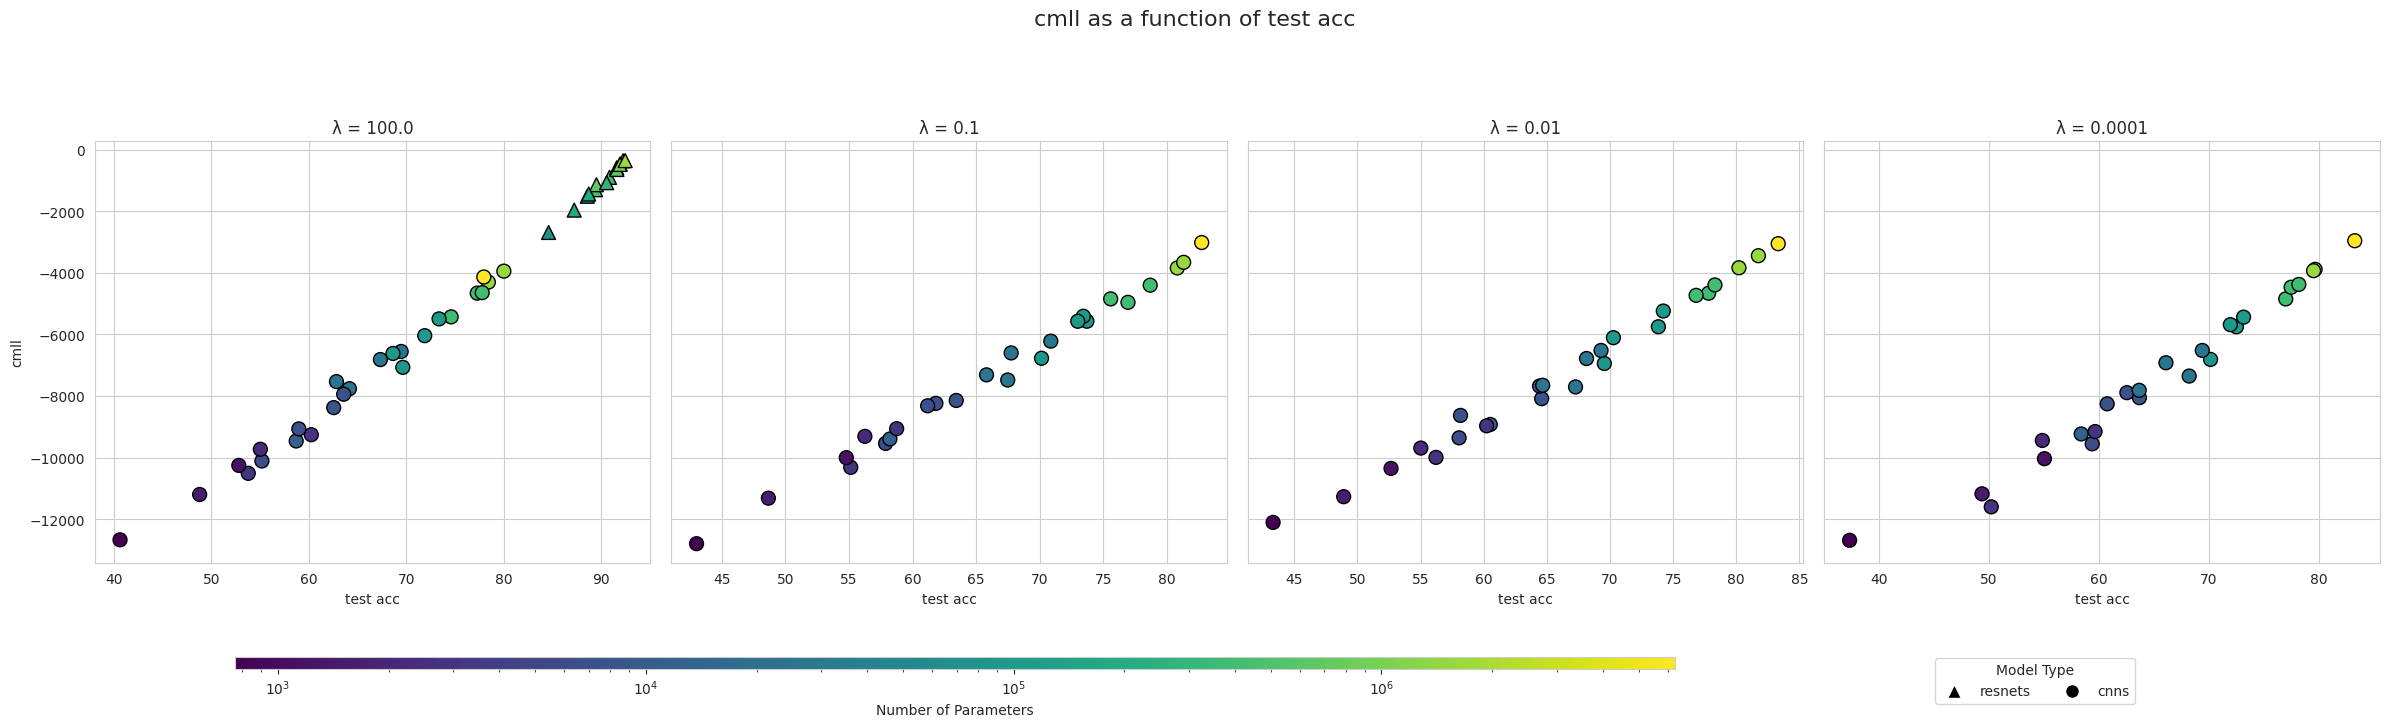

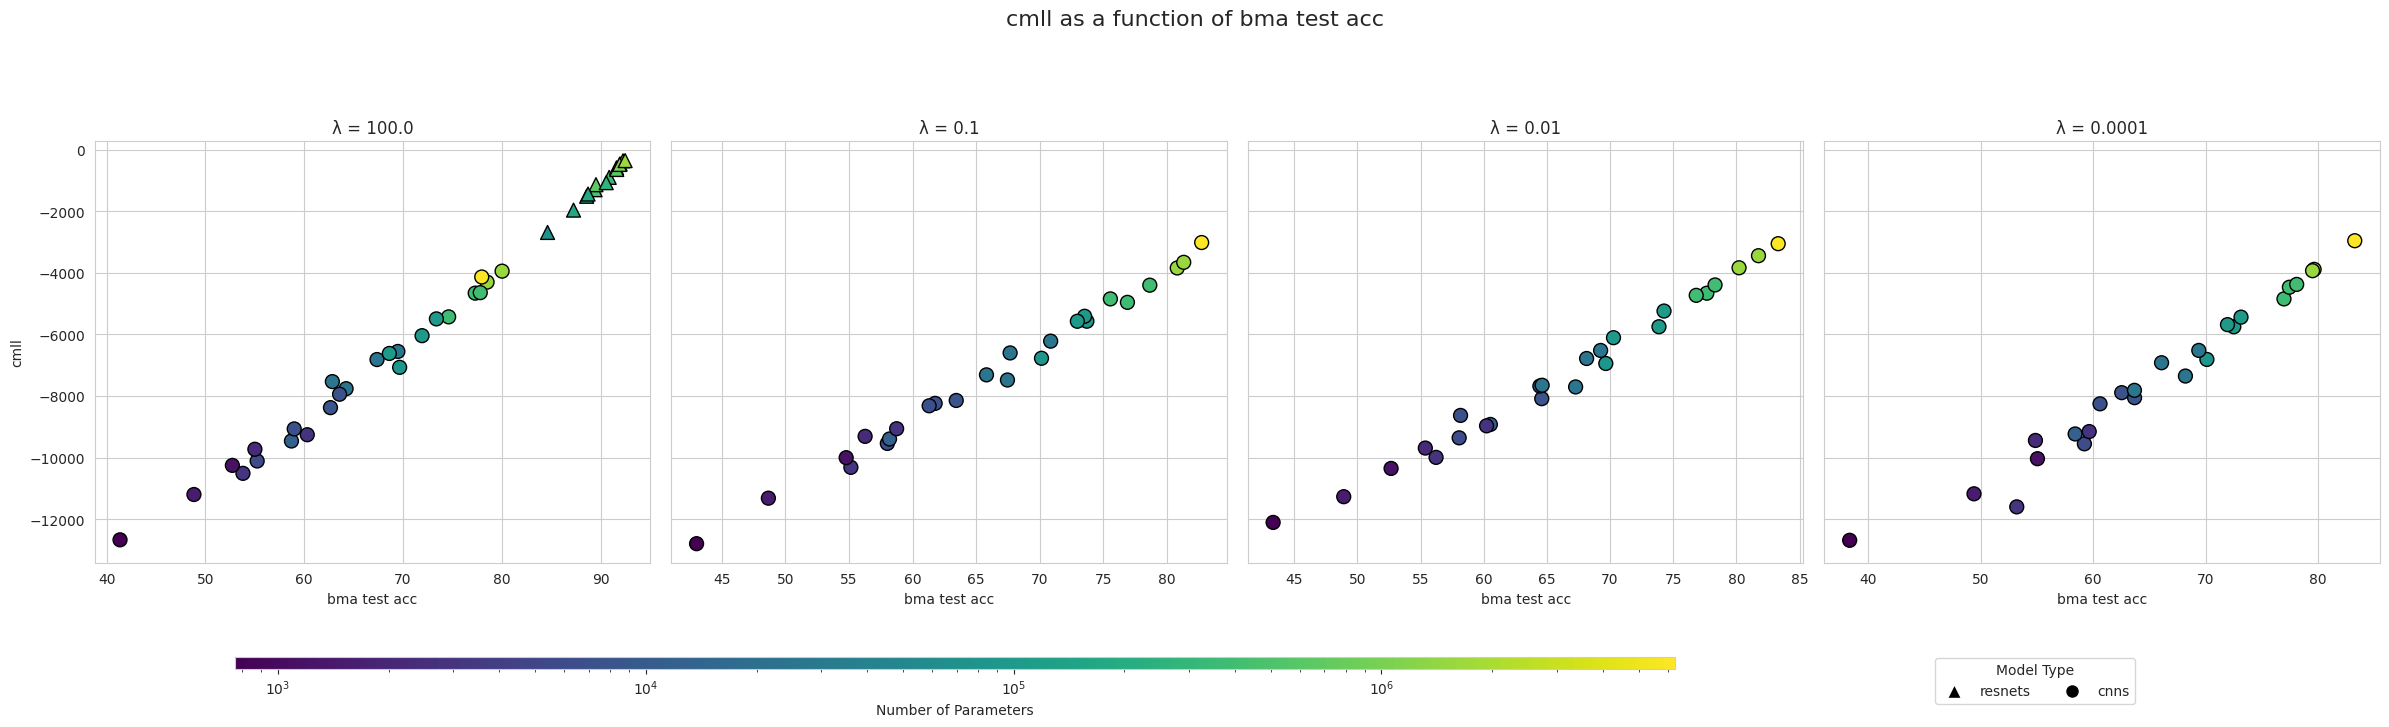

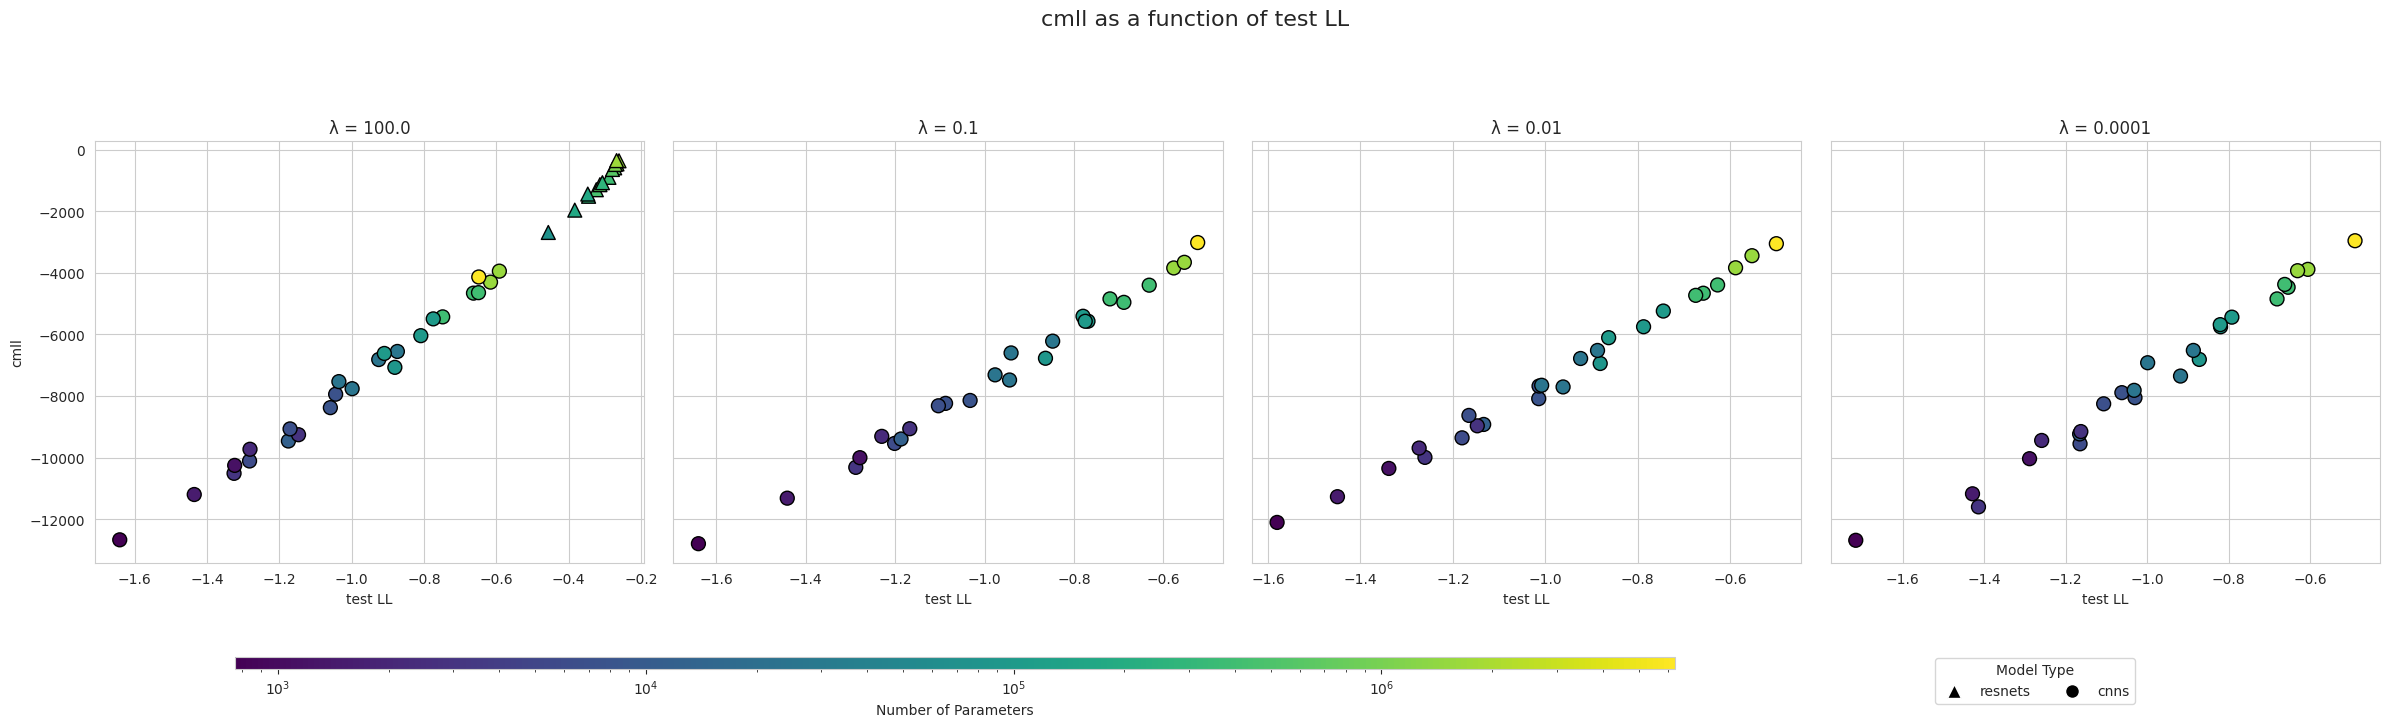

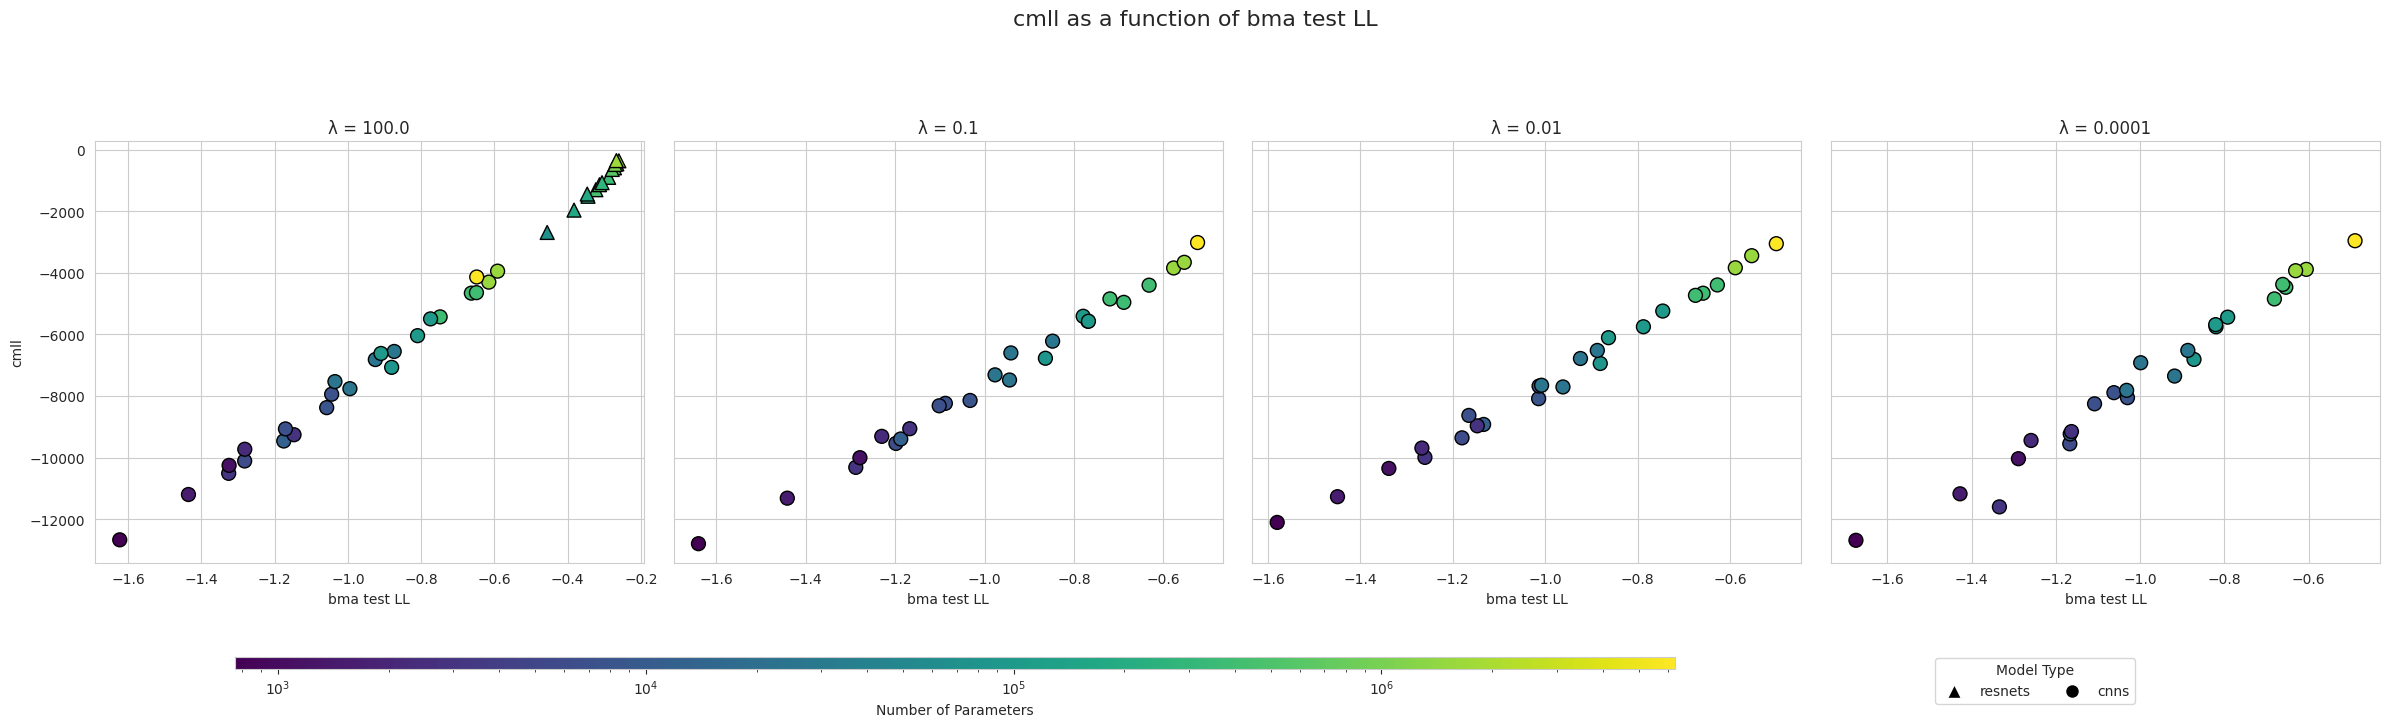

In [19]:
# Example call to the function
plot_cmll_mll_by_lambda_with_markers(data_combined_cmll, ['test acc', 'bma test acc', 'test LL', 'bma test LL'], 'cmll',[100.0, 0.1, 0.01, 0.0001])

### Marginal Log-Likelihood (MLL)

In [20]:
def load_mll_data_from_directory(directory_path):
    all_files = []
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith("_la.csv"):  # Assuming the MLL files have '_la.csv' suffix
                model_type = 'cnns' if 'cnns' in root else 'resnets'
                parts = file.replace("_la.csv", "").split("_")
                if model_type == 'cnns':
                    # Extract decay, depth, width from the filename for CNNs
                    model_name = parts[3] + "_" + parts[4]  # depth_width
                else:
                    # Extract decay, arch, width from the filename for ResNets
                    model_name = parts[2] + "_" + parts[3]  # arch_width
                decay = parts[1]
                df = pd.read_csv(os.path.join(root, file))
                df['model_type'] = model_type
                df['model_name'] = model_name
                df['decay'] = decay
                all_files.append(df[['model_type', 'model_name', 'decay', 'marglik']])
    return pd.concat(all_files, ignore_index=True)

# Example usage
cnns_mll_directory = "cifar/results/cifar10/new_hypers/cnns"
resnets_mll_directory = "cifar/results/cifar10/new_hypers"

data_mll_cnns = load_mll_data_from_directory(cnns_mll_directory)
data_mll_resnets = load_mll_data_from_directory(resnets_mll_directory)
data_combined_mll = pd.concat([data_mll_cnns, data_mll_resnets], ignore_index=True)
data_combined_mll['decay'] = data_combined_mll['decay'].astype(float)

print(data_combined_mll.head())

  model_type model_name  decay   marglik
0       cnns     cnn1_4  100.0 -1.767856
1       cnns     cnn1_8  100.0 -1.616864
2       cnns    cnn1_16  100.0 -1.595418
3       cnns    cnn1_32  100.0 -1.622043
4       cnns    cnn1_64  100.0 -1.656979


/tmp/ipykernel_1375255/2219322343.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_files, ignore_index=True)


In [21]:
data_full_combined = pd.merge(data_combined_cmll, data_combined_mll, on=['model_type', 'model_name', 'decay'], how='left')
data_full_combined=data_full_combined.drop_duplicates()
print(data_full_combined.head())

  num_params  decay  best temperature  test acc  bma test acc  bma s3 acc  \
0        764  100.0          1.000000     40.63         41.35   43.920000   
2       1516  100.0          0.020000     48.80         48.83   51.213333   
4       3020  100.0          0.000004     53.79         53.79   54.746667   
6       6028  100.0          0.100000     55.19         55.23   56.306667   
8      12044  100.0          0.000400     58.71         58.70   59.453333   

    test LL  bma test LL          cmll model_type model_name   marglik  
0 -1.641690    -1.622817 -12670.357060       cnns     cnn1_4 -1.767856  
2 -1.435591    -1.435237 -11199.204717       cnns     cnn1_8 -1.616864  
4 -1.325444    -1.325444 -10512.055303       cnns    cnn1_16 -1.595418  
6 -1.282567    -1.281831 -10110.627568       cnns    cnn1_32 -1.622043  
8 -1.175139    -1.175124  -9461.787724       cnns    cnn1_64 -1.656979  


/tmp/ipykernel_1375255/2244089207.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for global title and colorbar


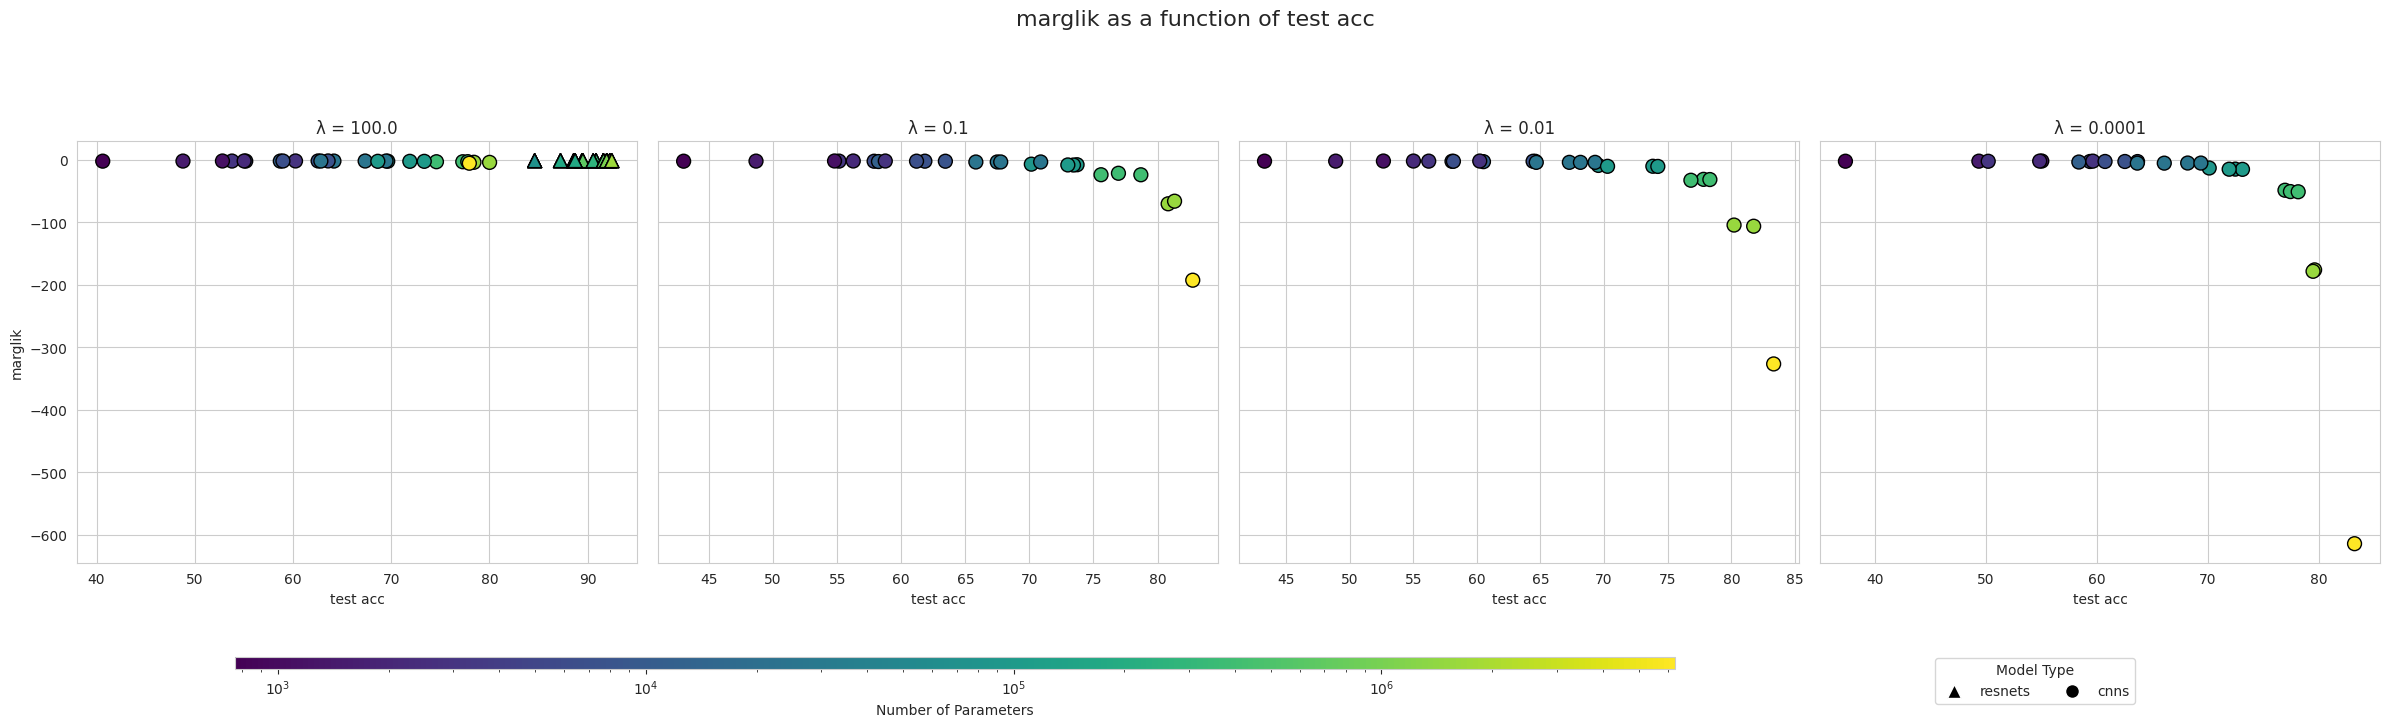

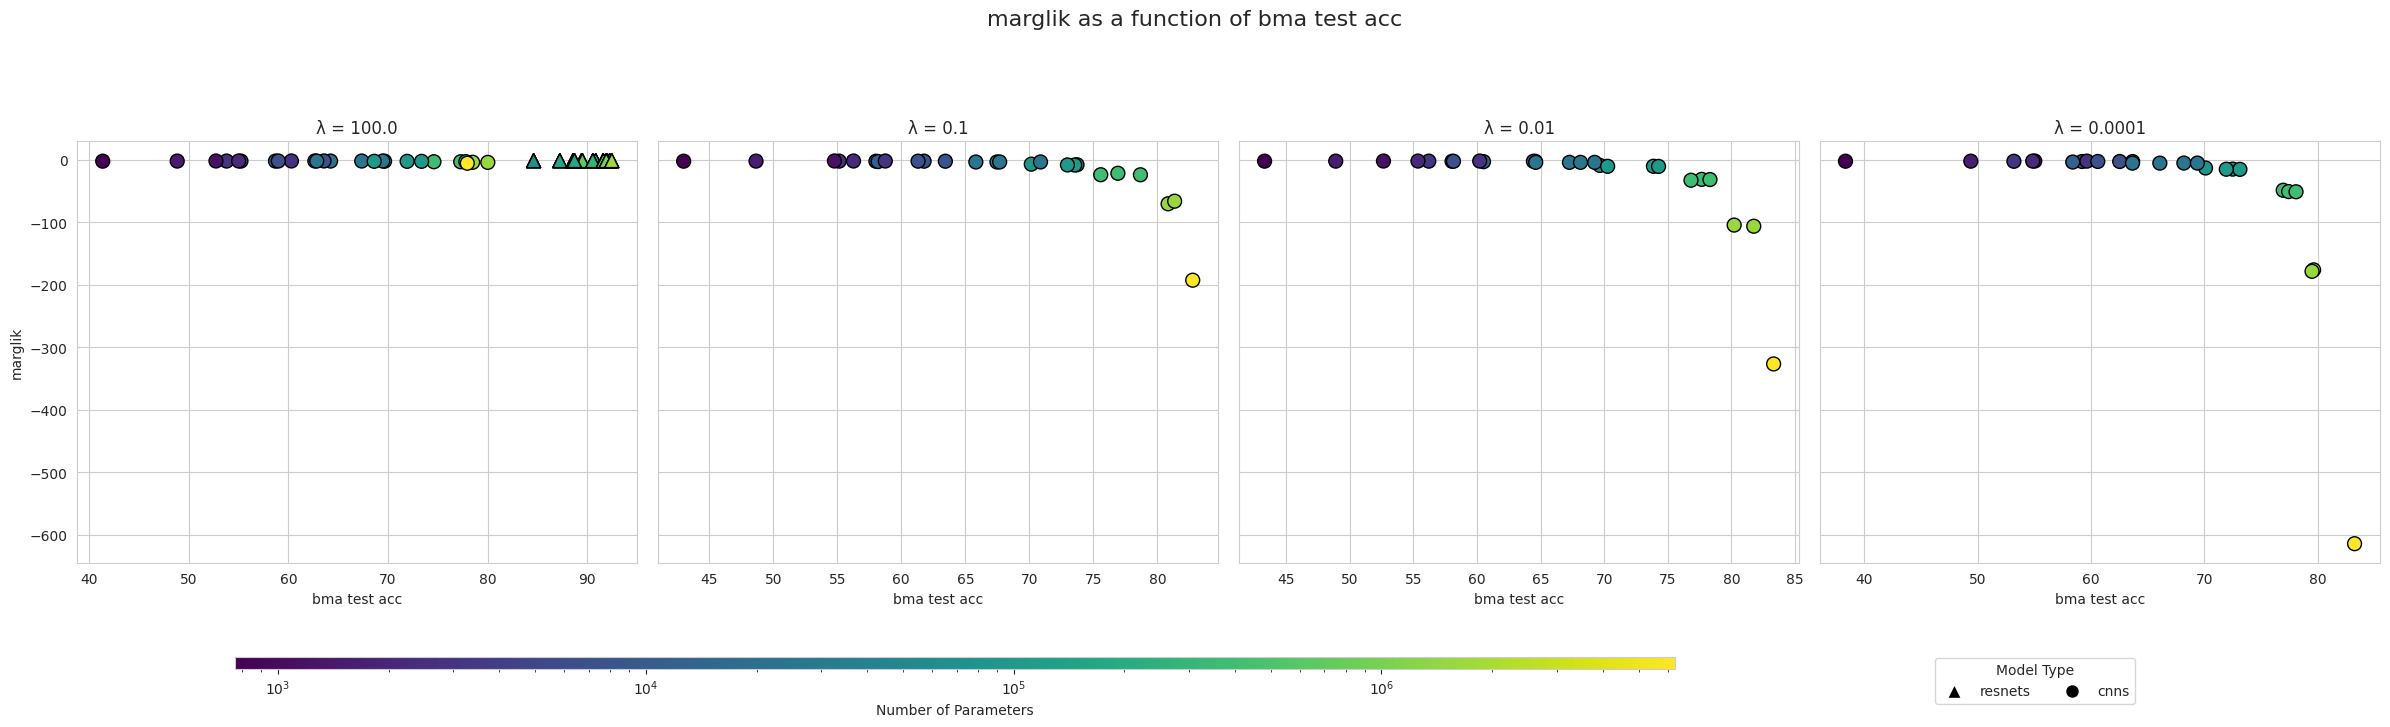

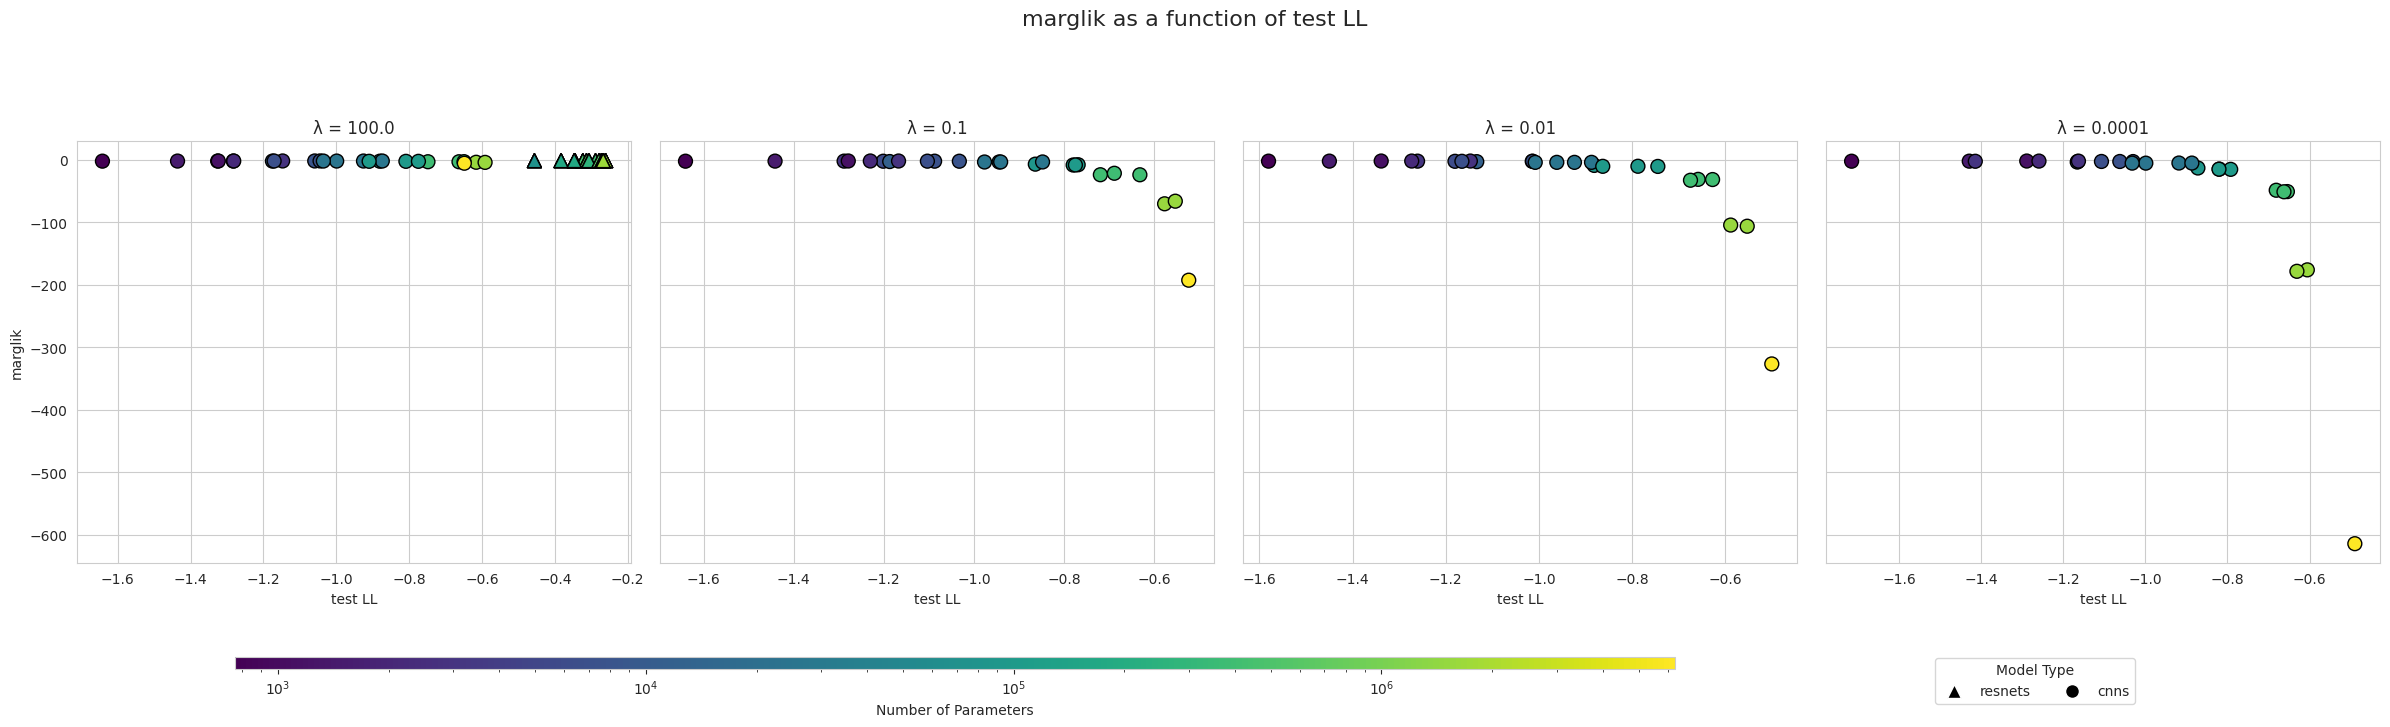

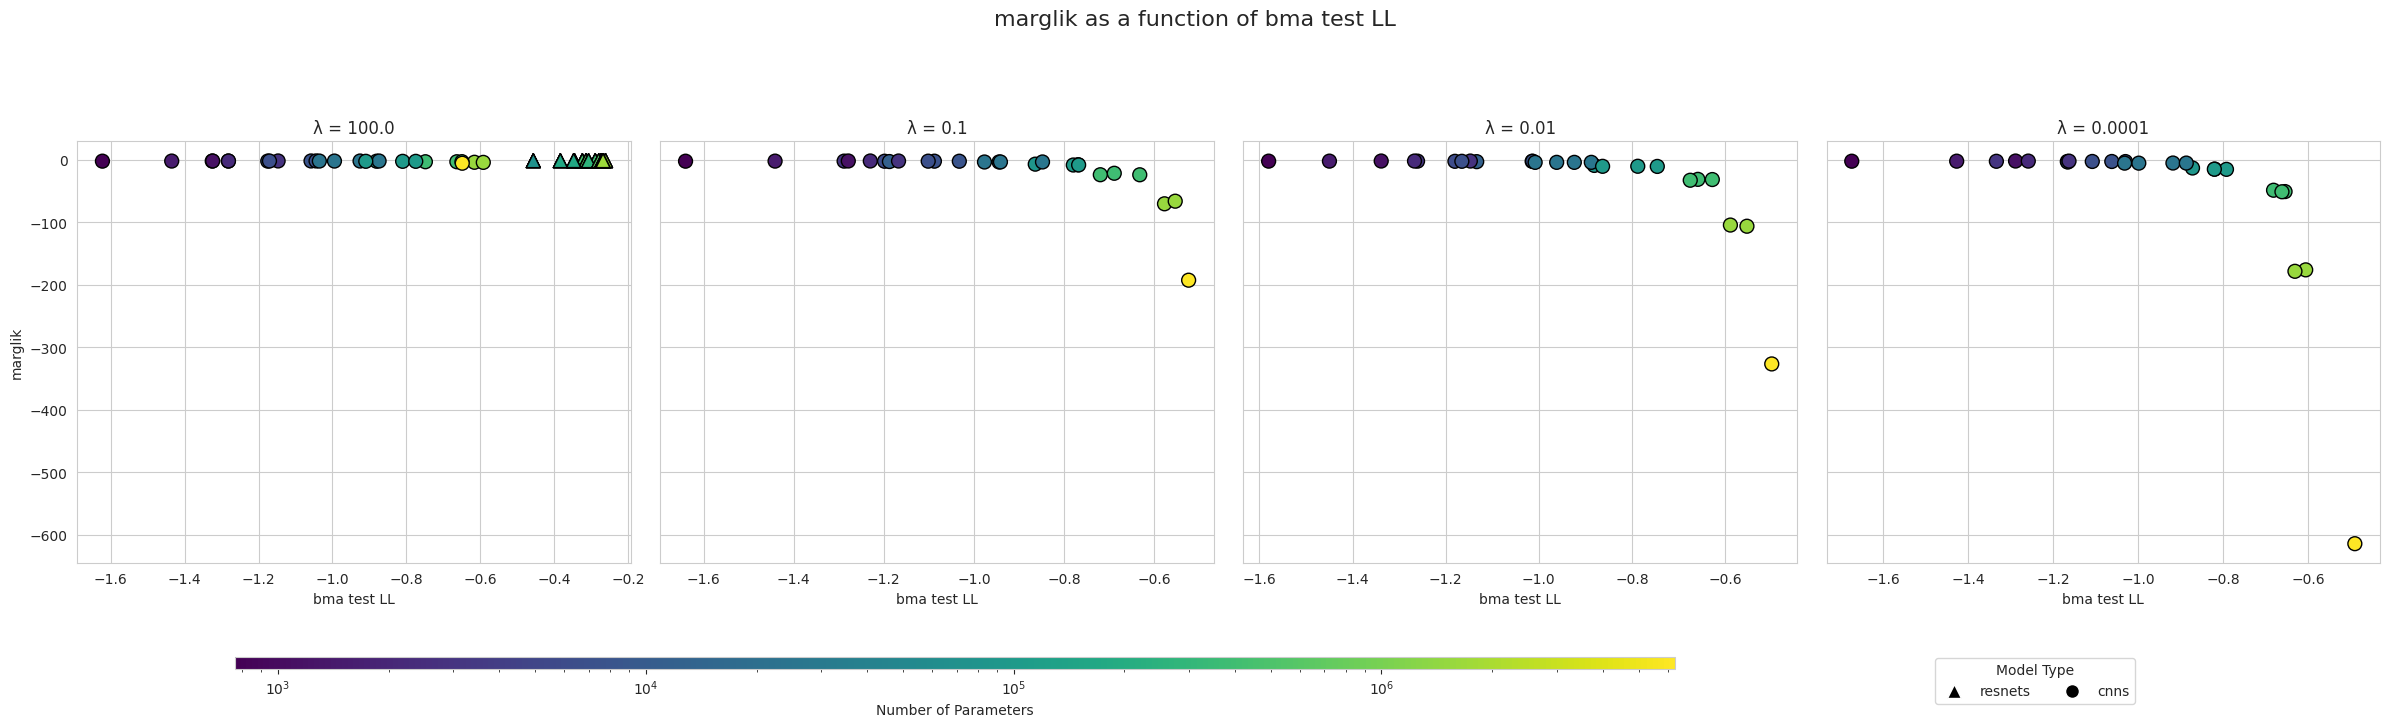

In [22]:
plot_cmll_mll_by_lambda_with_markers(data_full_combined, ['test acc', 'bma test acc', 'test LL', 'bma test LL'], 'marglik',[100.0, 0.1, 0.01, 0.0001])

### Plot both MLL and CMLL on same plot

/tmp/ipykernel_1375255/2736327799.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for global title and colorbar


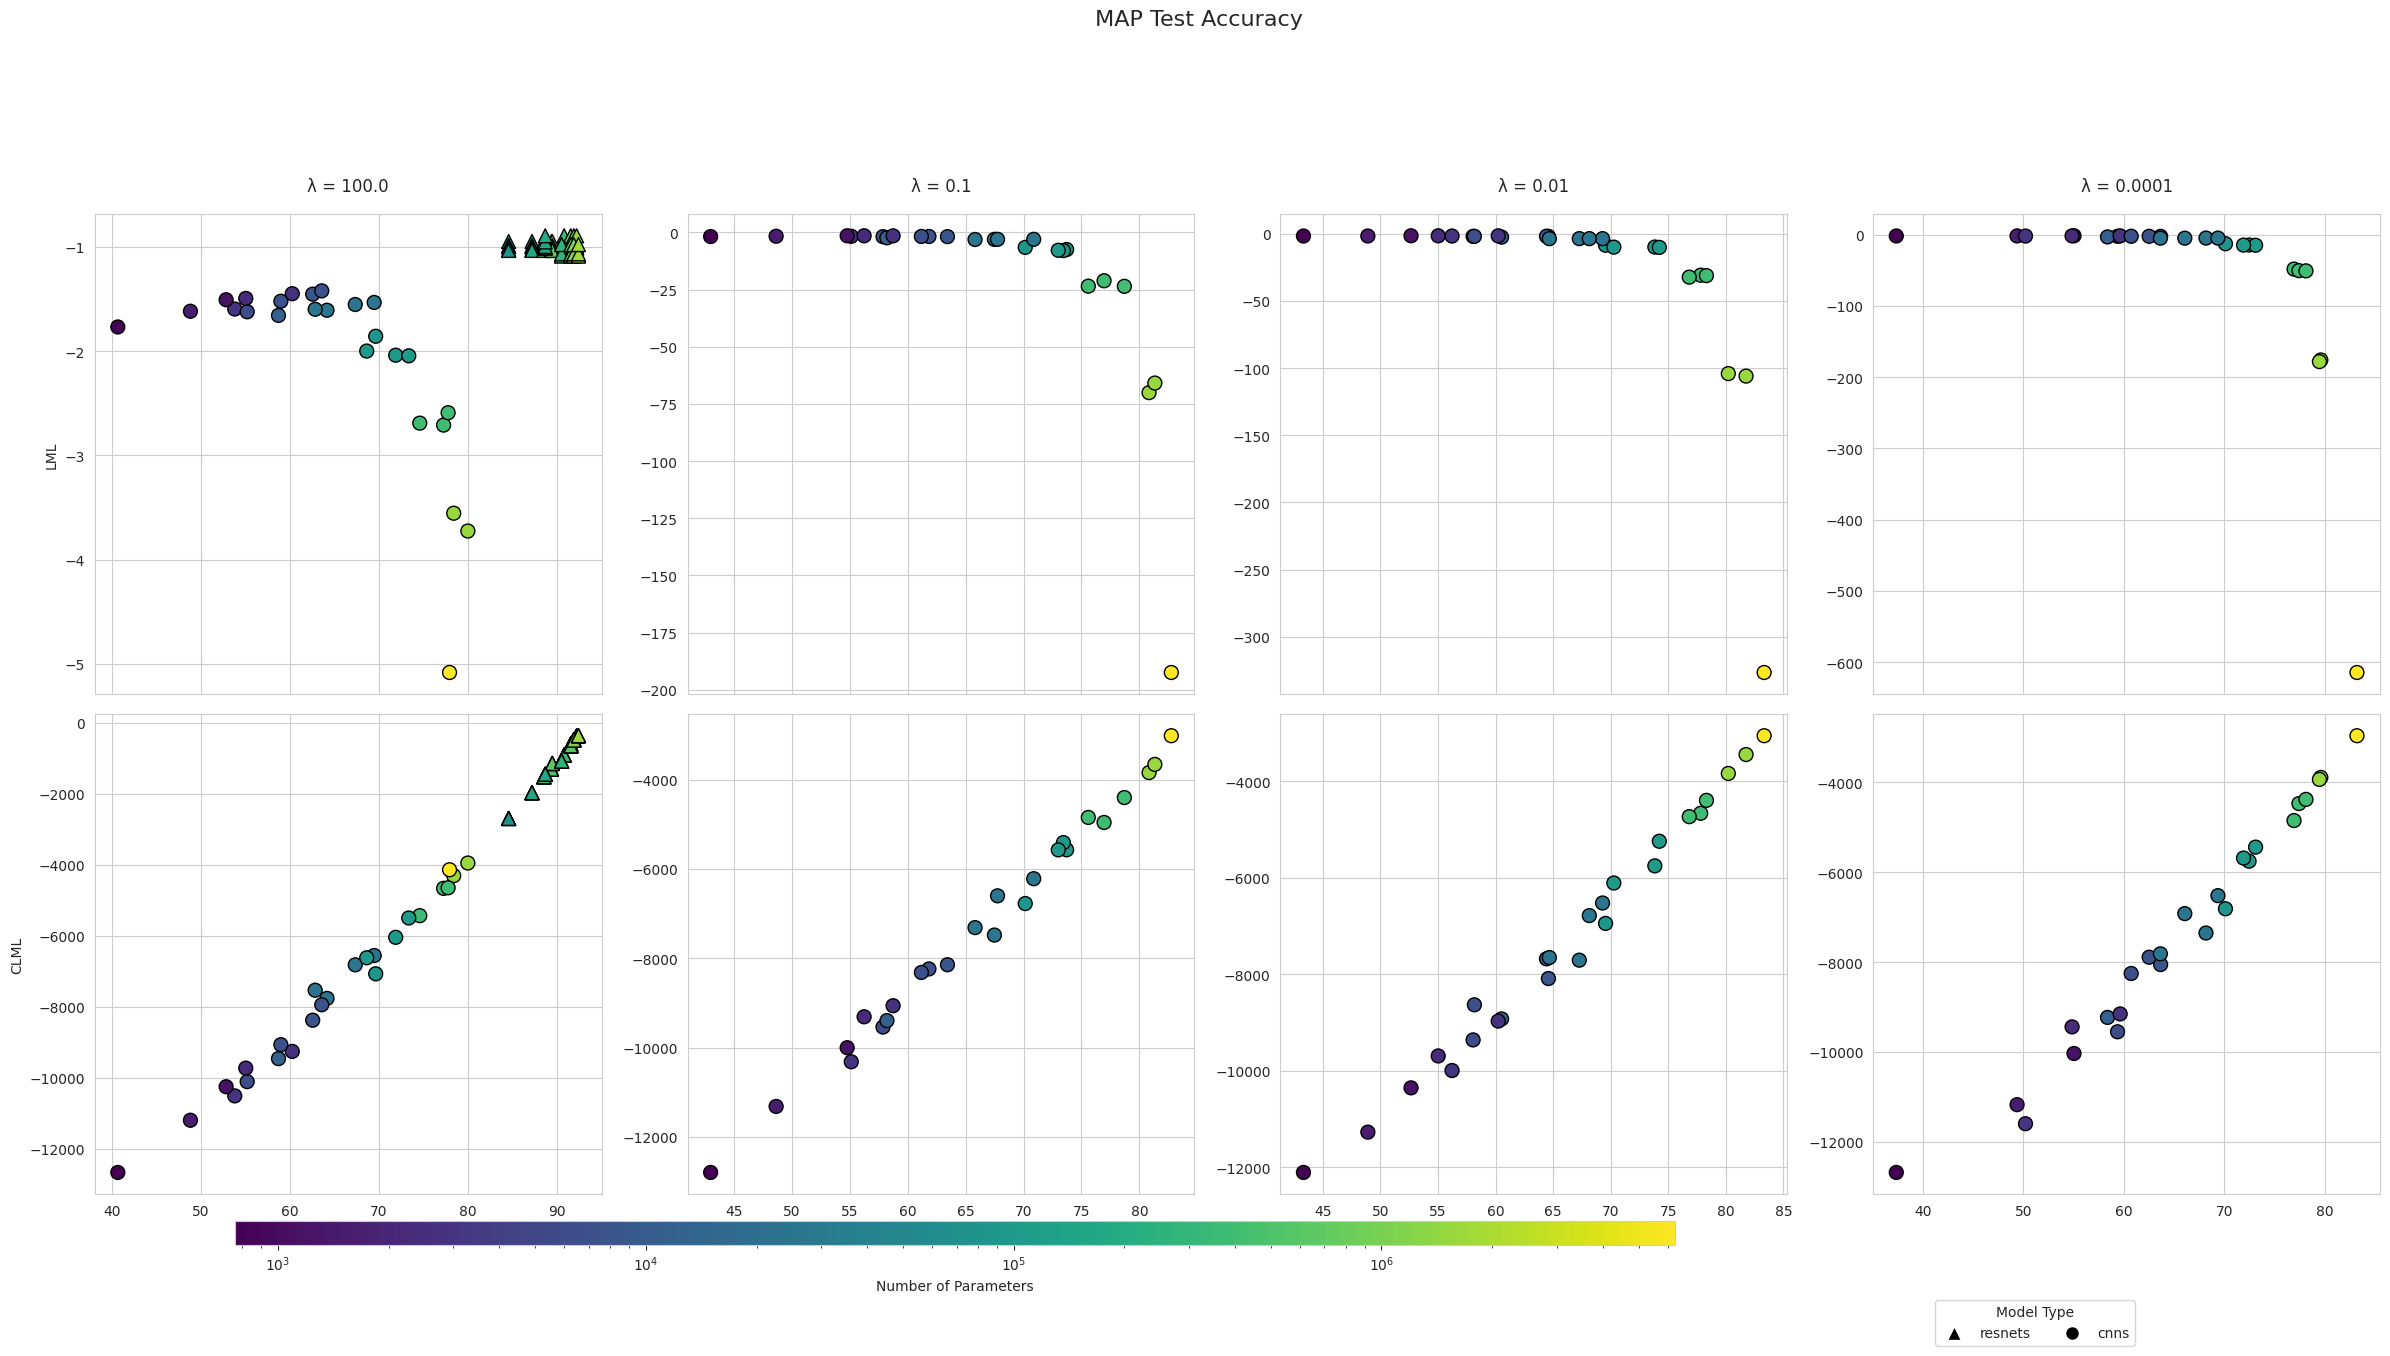

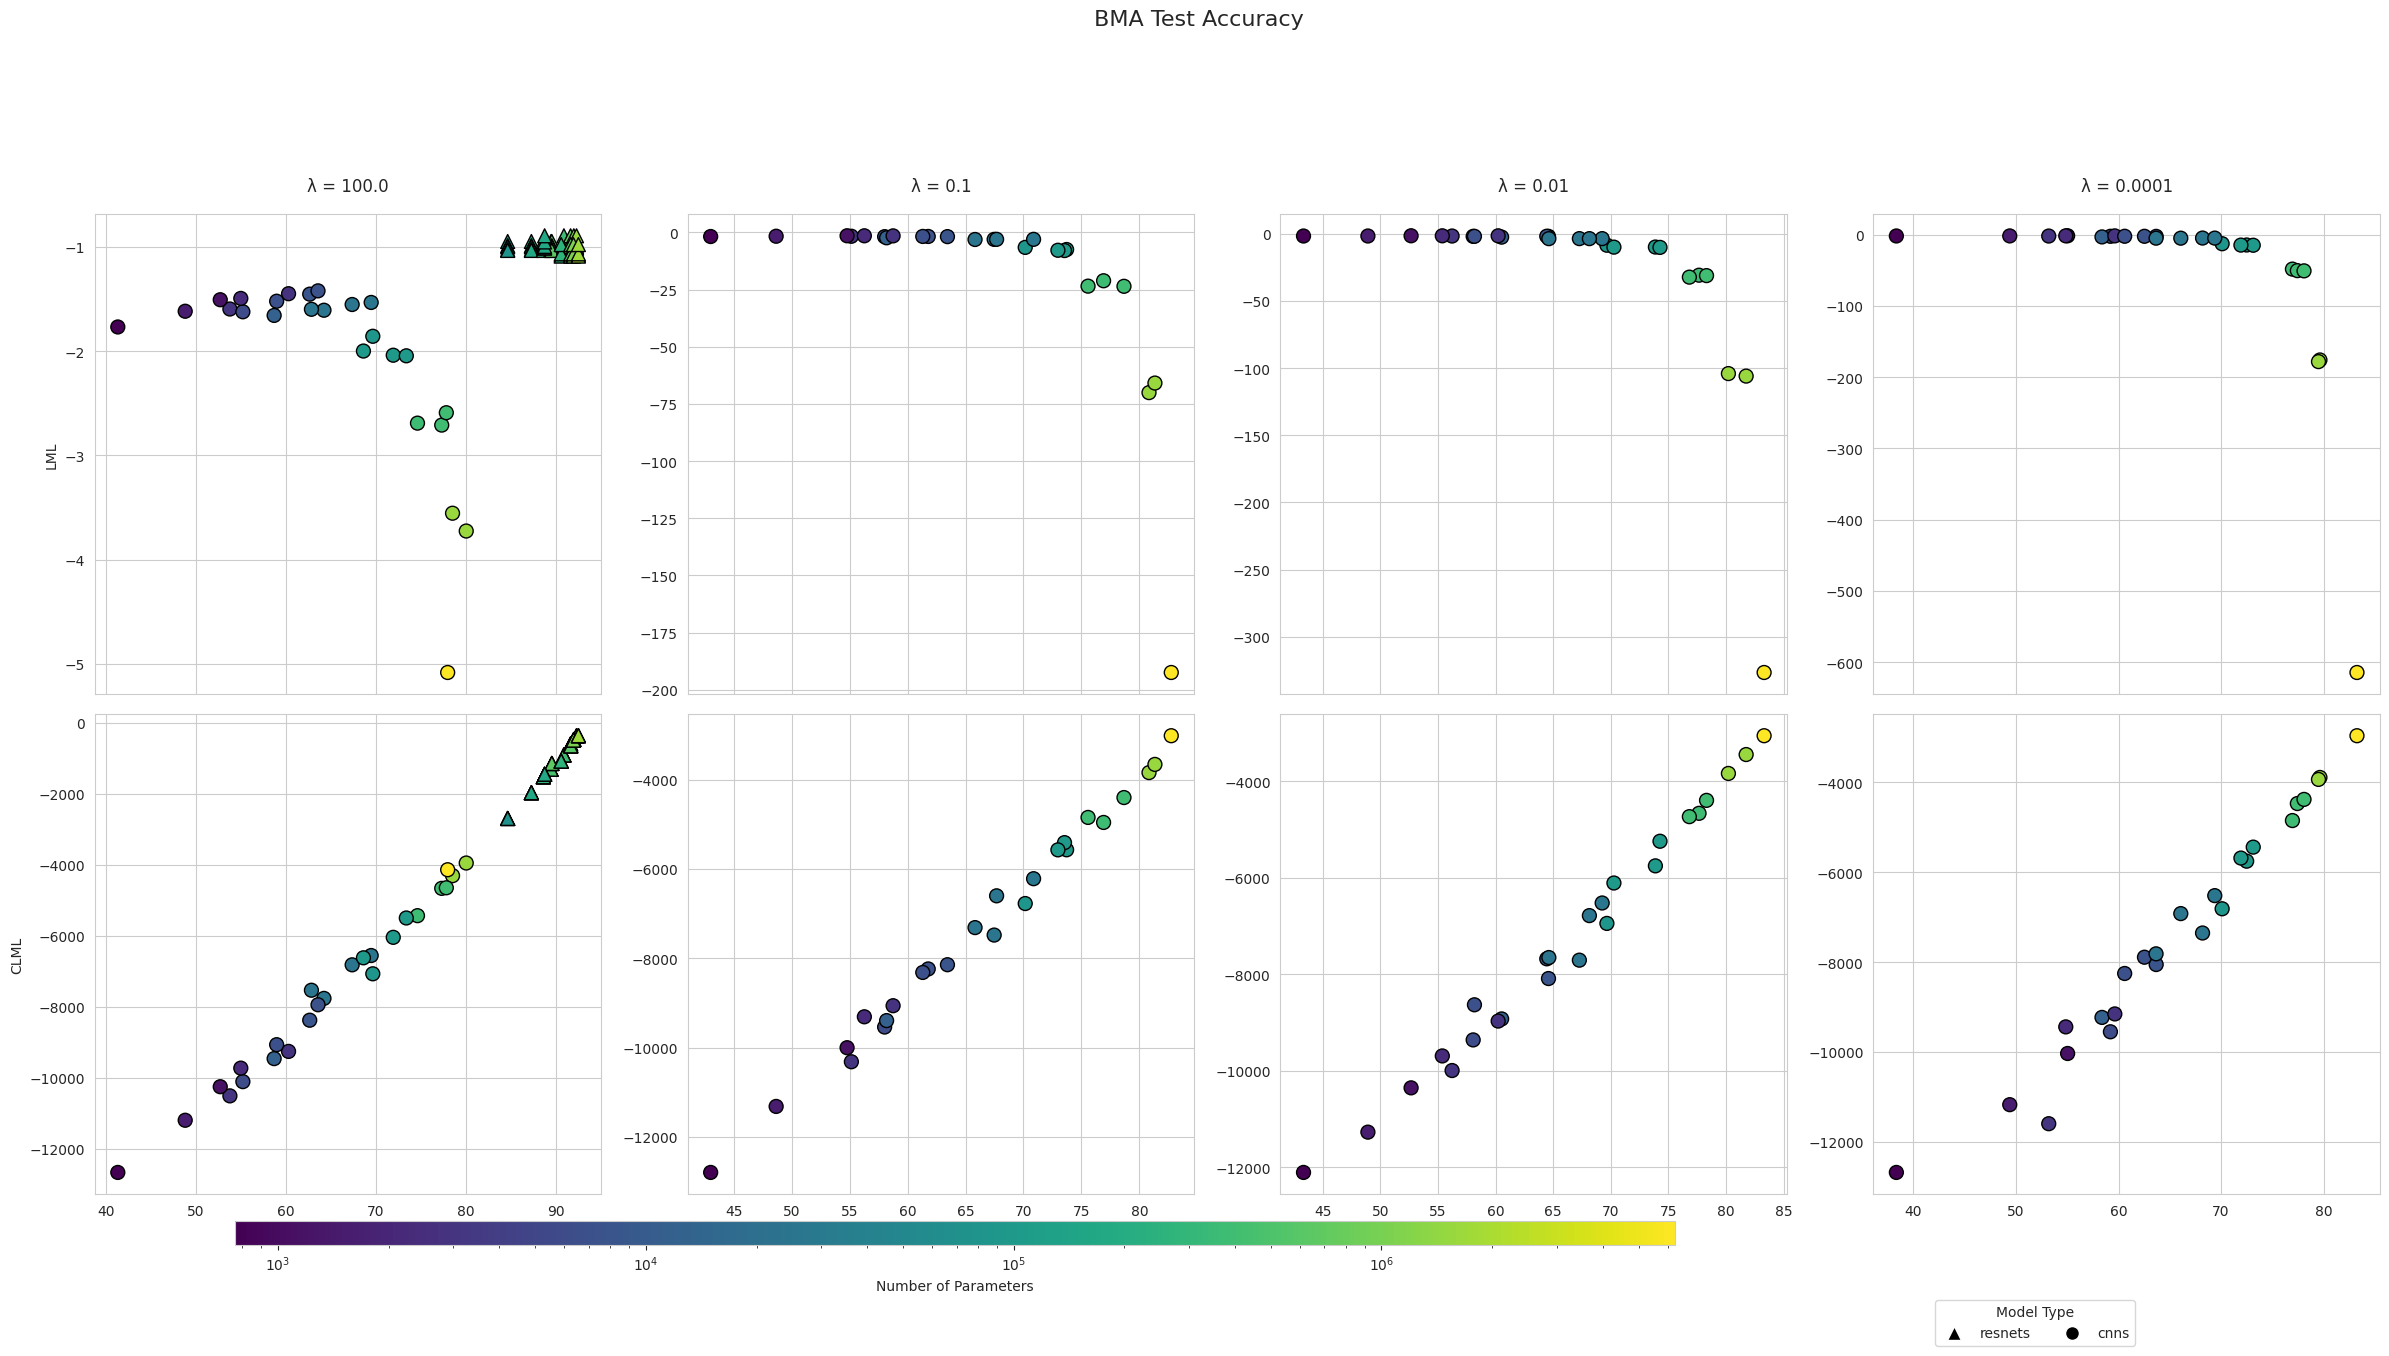

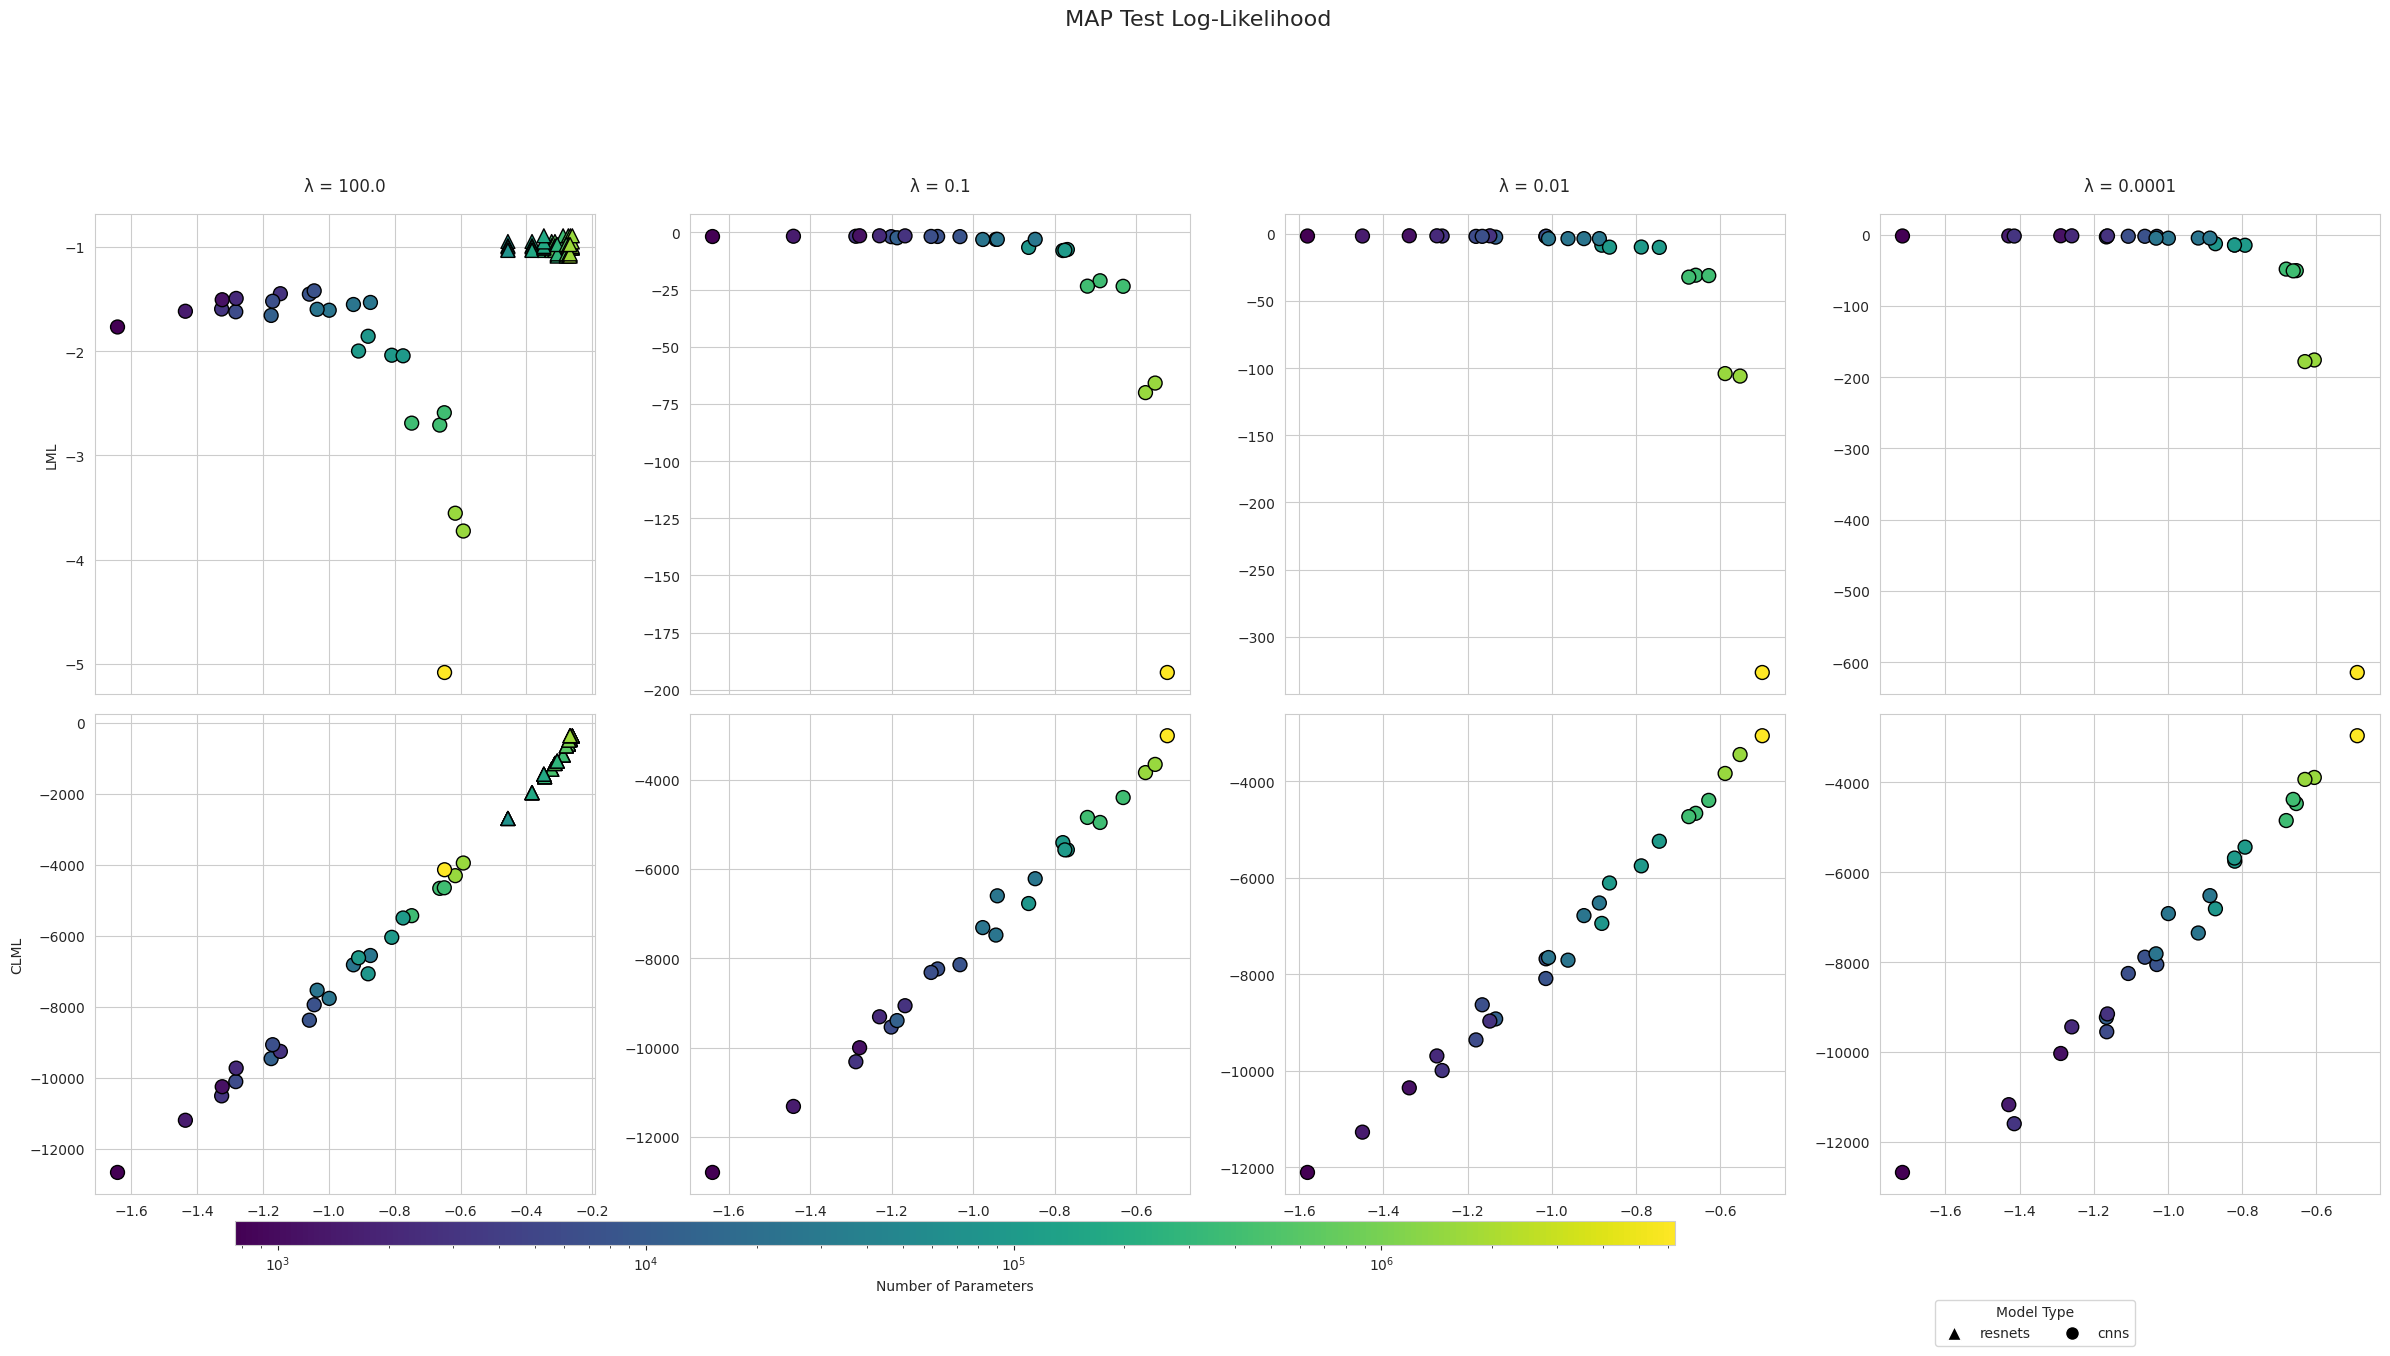

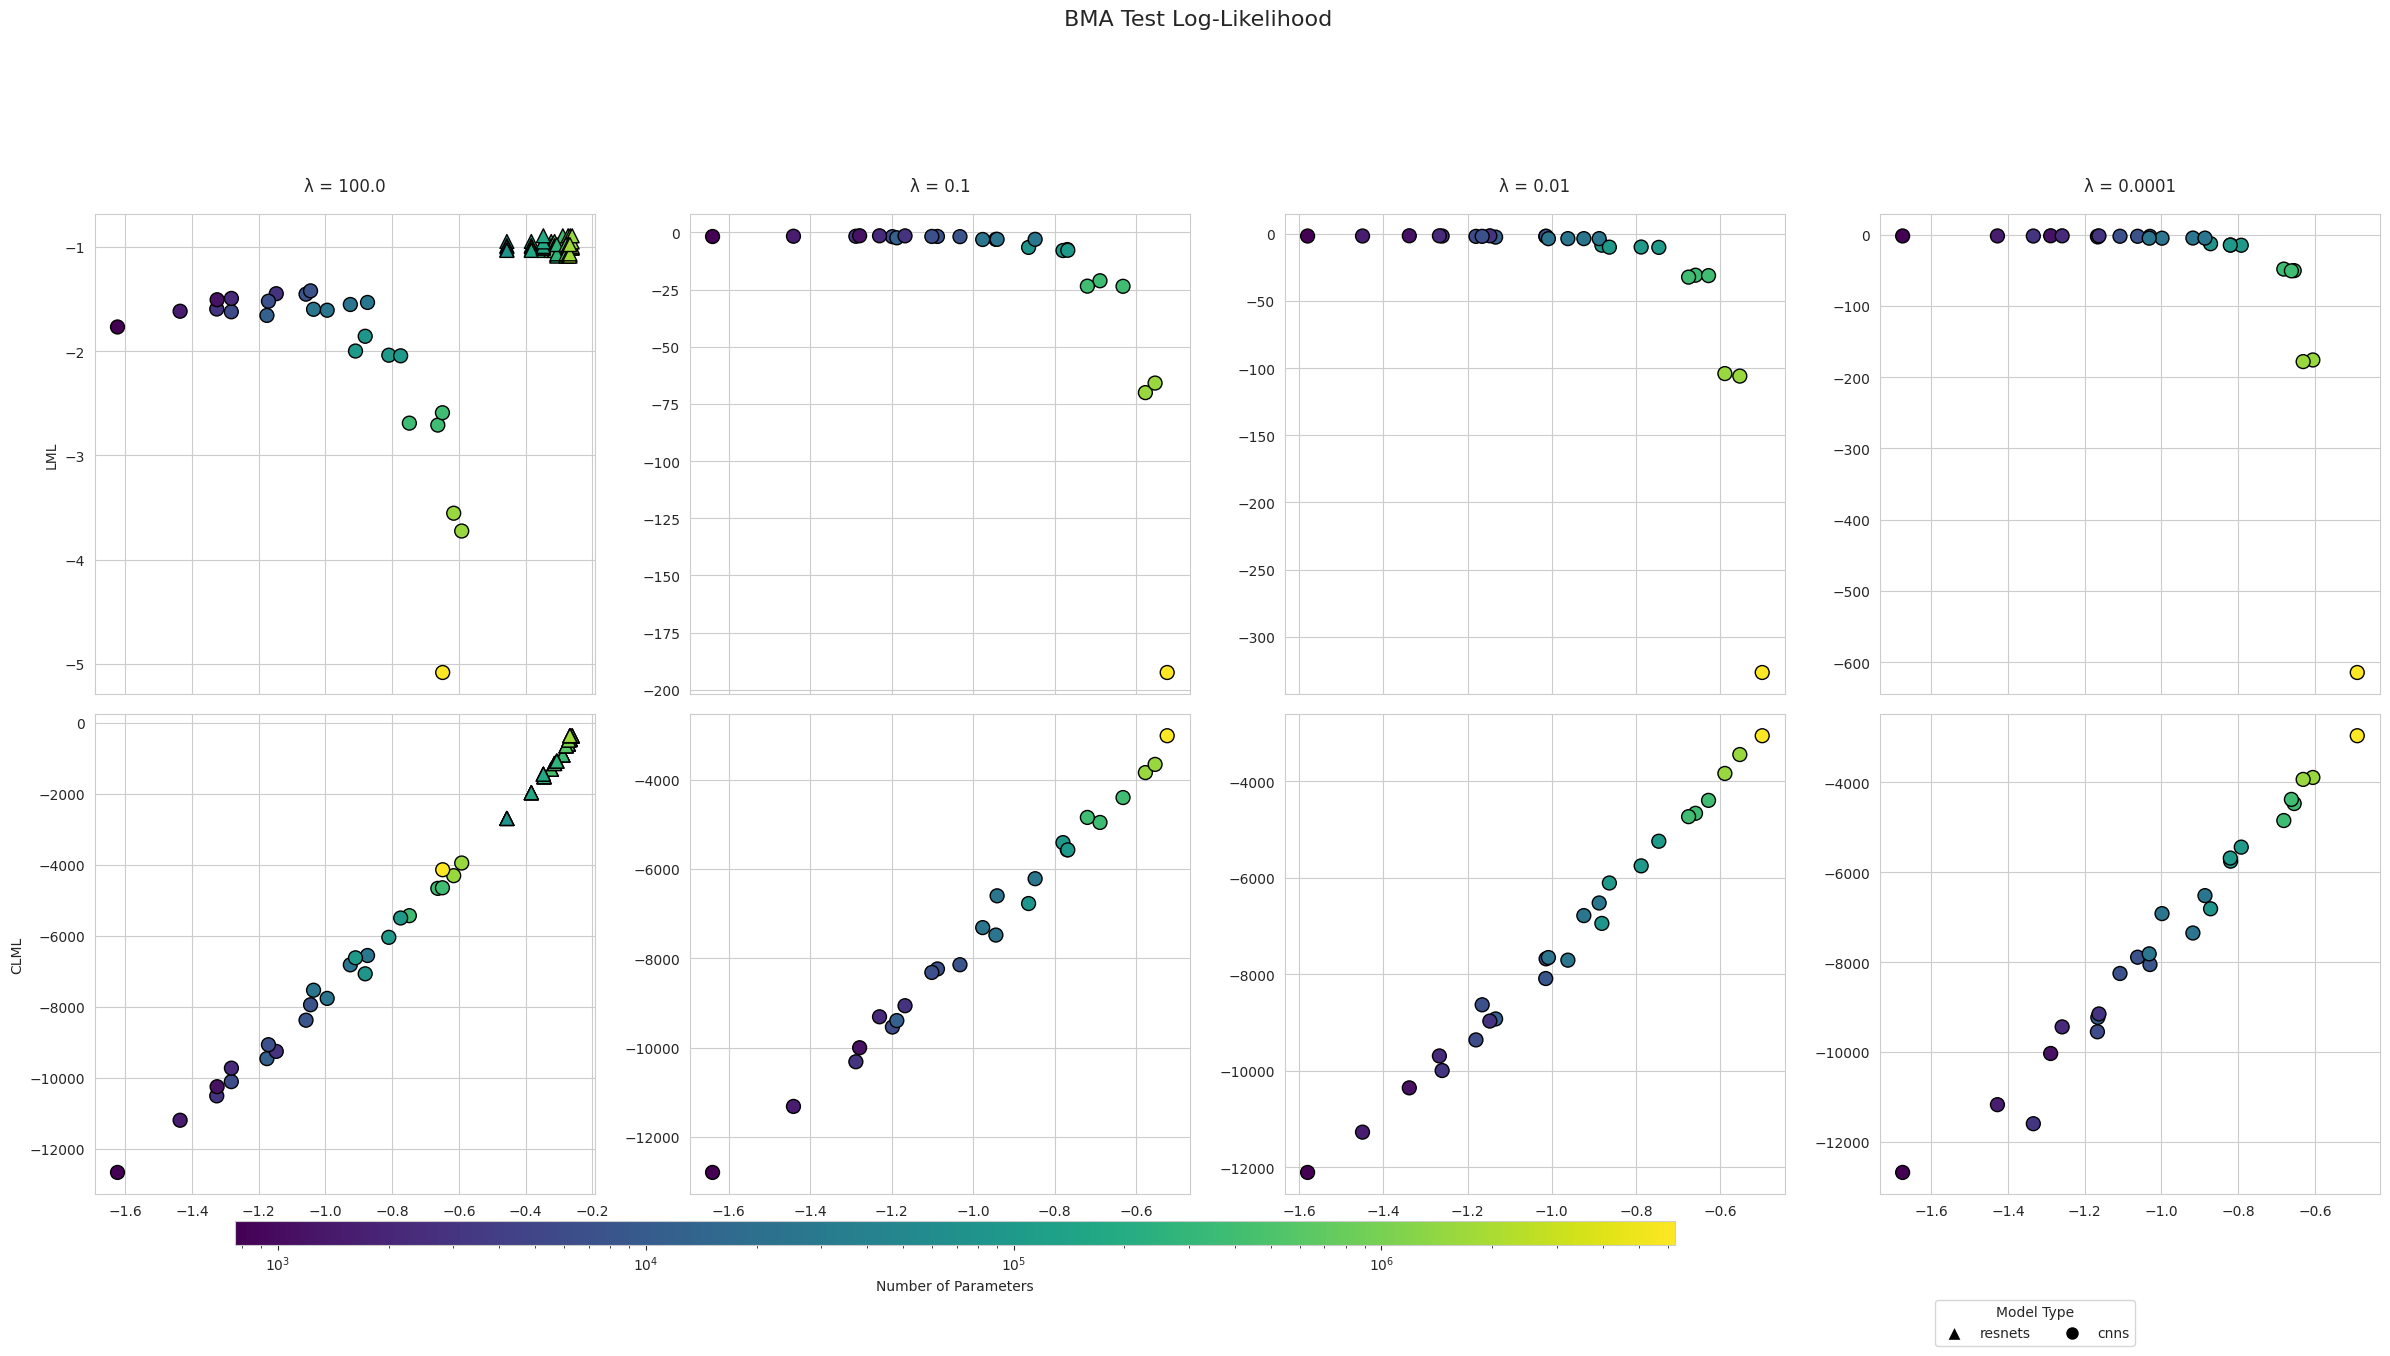

In [32]:
def plot_both_cmll_mll_by_lambda_with_markers(data, x_vars, y_vars, lambda_values):
    sns.set_style("whitegrid")
    n_cols = len(lambda_values)
    n_rows = len(y_vars)
    marker_dict = {'resnets': '^', 'cnns': 'o'}  # Mapping from model type to marker style

    variable_aliases = {
        'test acc': 'MAP Test Accuracy',
        'bma test acc': 'BMA Test Accuracy',
        'test LL': 'MAP Test Log-Likelihood',
        'bma test LL': 'BMA Test Log-Likelihood',
        'marglik': 'LML',
        'cmll': 'CLML'
    }

    data['decay'] = data['decay'].astype(float)

    for x_var in x_vars:
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*6), sharex='col')
        fig.suptitle(f' {variable_aliases.get(x_var, x_var)}', fontsize=16, y=1.05)

        scatters = []
        for j, y_var in enumerate(y_vars):
            sharey = 'row' if y_var == 'cmll' else None
            for i, lambd in enumerate(lambda_values):
                ax = axes[j, i]
                subset = data[data['decay'] == lambd]
                for model_type in marker_dict.keys():
                    model_subset = subset[subset['model_type'] == model_type]
                    scatter = ax.scatter(model_subset[x_var], model_subset[y_var], c=model_subset['num_params'], cmap='viridis', s=100, edgecolor='k', norm=colors.LogNorm(data['num_params'].min(), data['num_params'].max()), marker=marker_dict[model_type])
                    scatters.append(scatter)

                if i == 0:
                    ax.set_ylabel(variable_aliases.get(y_var, y_var))
                if j == 0:
                    ax.set_title(f'λ = {lambd}', y=1.03)
                ax.set_xlabel('')
                ax.grid(True)

        # Add a single horizontal colorbar below the plot
        cbar_ax = fig.add_axes([0.1, 0.02, 0.6, 0.02]) # Adjust these values as needed
        cbar = fig.colorbar(scatters[0], cax=cbar_ax, orientation='horizontal', label='Number of Parameters')
        cbar.ax.tick_params(labelsize=10)

        # Add legend for model types below the plot
        legend_labels = [plt.Line2D([0], [0], color='w', markerfacecolor='k', marker=m, linestyle='None', markersize=10) for m in marker_dict.values()]
        fig.legend(legend_labels, marker_dict.keys(), title='Model Type', loc='upper center', bbox_to_anchor=(0.85, -0.02), ncol=3, fontsize=10)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for global title and colorbar
        plt.show()
plot_both_cmll_mll_by_lambda_with_markers(data_full_combined, ['test acc', 'bma test acc', 'test LL', 'bma test LL'], ['marglik','cmll'],[100.0, 0.1, 0.01, 0.0001])
